In [157]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier



In [16]:
df = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')
df['ShapeFactor5'] = df['MajorAxisLength'] / df['Perimeter']
df_test['ShapeFactor5'] = df_test['MajorAxisLength'] / df_test['Perimeter']

In [106]:
X = df.drop(columns=['Class'])
y = df['Class']

# Feature selection

In [107]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [feature for feature in df.columns if feature != 'Class']
forest = RandomForestClassifier(random_state=311)
forest.fit(X, y)

RandomForestClassifier(random_state=311)

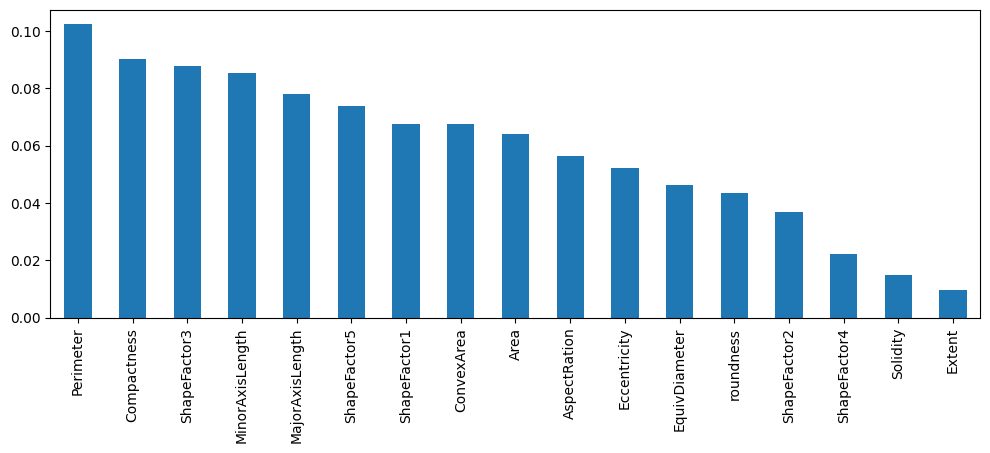

In [135]:
importances = forest.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(12, 4))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
importance_threshold = forest_importances.max()


Wynika z tego, że możemy nie brać pod uwagę niektórych kolumn, ale musimy sprawdzić jeszcze, jak dużo z nich usunąć

In [85]:
def evaluate_feature_importance(X, y, importance_threshold):
    forest = RandomForestClassifier(random_state=311)
    forest.fit(X, y)
    importances = forest.feature_importances_

    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
    feature_importances = feature_importances.sort_values('importance', ascending=True)

    clf = RandomForestClassifier(random_state=311)
    clf.fit(X, y)

    results = []

    for i in range(len(feature_importances)):
        selected_features = feature_importances['feature'].iloc[i:]

        if feature_importances['importance'].iloc[i] > importance_threshold:
            break

        pipeline = Pipeline(steps=[
            ('classifier', clf)
        ])

        scores = cross_val_score(pipeline, X[selected_features], y, cv=5, scoring='accuracy')

        results.append({
            'num_features': len(selected_features),
            'accuracy': scores.mean(),
            'std': scores.std()
        })

    return pd.DataFrame(results)

In [86]:
results_with_1 = evaluate_feature_importance(X, y, importance_threshold)
results_with_2 = evaluate_feature_importance(X, y, importance_threshold-0.0001)

<Axes: xlabel='num_features'>

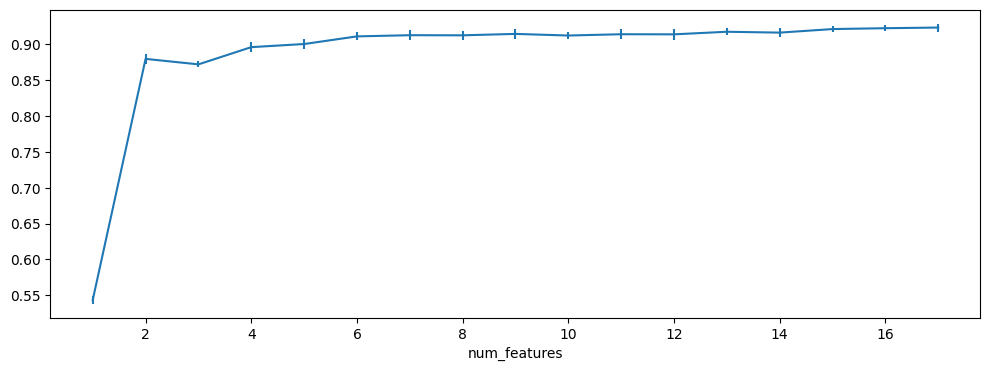

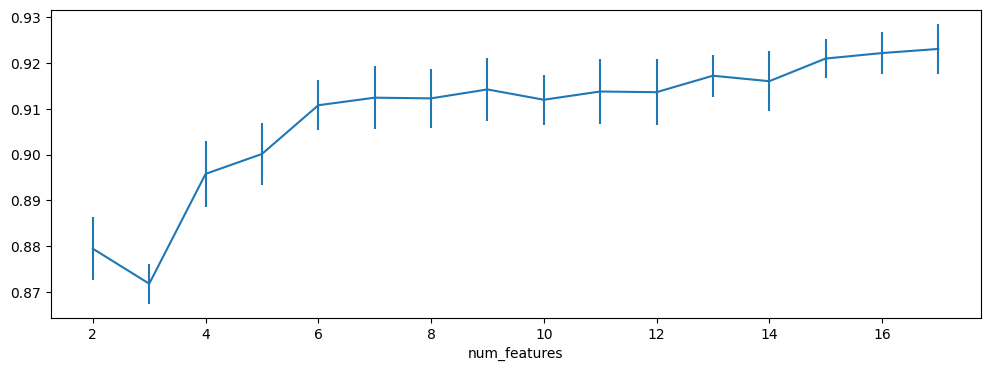

In [103]:
results_with_1.plot(x='num_features', y='accuracy', yerr='std', figsize=(12, 4), legend=False)
results_with_2.plot(x='num_features', y='accuracy', yerr='std', figsize=(12, 4), legend=False)

In [151]:
print(feature_importances.iloc[:]['feature'])

8              Extent
9            Solidity
15       ShapeFactor4
13       ShapeFactor2
10          roundness
7       EquivDiameter
5        Eccentricity
4        AspectRation
0                Area
6          ConvexArea
12       ShapeFactor1
16       ShapeFactor5
2     MajorAxisLength
3     MinorAxisLength
14       ShapeFactor3
11        Compactness
1           Perimeter
Name: feature, dtype: object


Z wykresów wynika, że powinniśmy na pewno usunąć kolumny ShapeFactor2, AspectRatio i ShapeFactor3

Do tego możemy wziąć również pod uwagę kolumny których usuwanie podczas wykonania funkcji *evaluate_feature_importance* nie zmienia znacznie parametru accuracy modelu

In [153]:
features_to_drop1 = ['ShapeFactor2', 'AspectRation', 'ShapeFactor3']
features_to_drop2 = ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1']
features_to_drop3 = ['roundness' ,'EquivDiameter' ,'Eccentricity', 'AspectRation', 'Area', 'ConvexArea', 'ShapeFactor1', 'Extent', 'Solidity', 'ShapeFactor2']
mask1 = feature_importances['feature'].isin(features_to_drop1)
mask2 = feature_importances['feature'].isin(features_to_drop2)
mask3 = feature_importances['feature'].isin(features_to_drop3)
feature_names1 = feature_importances[~mask1]['feature']
feature_names2 = feature_importances[~mask2]['feature']
feature_names3 = feature_importances[~mask3]['feature']

clf = RandomForestClassifier(random_state=311)

pipeline = Pipeline(steps=[
            ('classifier', clf)
        ])

scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
scores1 = cross_val_score(pipeline, X[feature_names1], y, cv=7, scoring='accuracy')
scores2 = cross_val_score(pipeline, X[feature_names2], y, cv=7, scoring='accuracy')
scores3 = cross_val_score(pipeline, X[feature_names3], y, cv=7, scoring='accuracy')

print("Scores\t\tMean\t\tStd")
print("-----\t\t----\t\t---")
print("scores\t\t{0}\t\t{1}".format(round(scores.mean(), 5), round(scores.std(), 5)))
print("scores1\t\t{0}\t\t{1}".format(round(scores1.mean(), 5), round(scores1.std(), 5)))
print("scores2\t\t{0}\t\t{1}".format(round(scores2.mean(), 5), round(scores2.std(), 5)))
print("scores3\t\t{0}\t\t{1}".format(round(scores3.mean(), 5), round(scores3.std(), 5)))


Scores		Mean		Std
-----		----		---
scores		0.92262		0.00485
scores1		0.92397		0.00318
scores2		0.92502		0.00631
scores3		0.91887		0.00804


Okazuje się że możemy usunąć bardzo dużo kolumn bez znacznej utraty accuracy lub usunąć pojedyncze kolumny co daje większą wartość accuracy niż wyjściowe dane. W dalszej części projektu będziemy starali się ustalić które podejście będzie najbardziej efektywne

# Tworzenie Pipeline'ów

In [147]:
def drop_columns(X, columns_to_drop):
    return X.drop(columns=columns_to_drop, axis=1)

In [148]:
drop_columns_transformer1 = FunctionTransformer(drop_columns, kw_args={'columns_to_drop': features_to_drop1})
drop_columns_transformer2 = FunctionTransformer(drop_columns, kw_args={'columns_to_drop': features_to_drop2})
drop_columns_transformer3 = FunctionTransformer(drop_columns, kw_args={'columns_to_drop': features_to_drop3})

preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop1', drop_columns_transformer1, feature_names1),
    ])

preprocessor2 = ColumnTransformer(
    transformers=[
        ('drop2', drop_columns_transformer2, feature_names2),
    ])

preprocessor3 = ColumnTransformer(
    transformers=[
        ('drop3', drop_columns_transformer3, feature_names3),
    ])



In [155]:
# potestujemy sobie teraz te wybrane kolumny razem ze skalowaniem i bez na gołych modelach: SVC, XGBoost, RandomForest, AdaBoost, LGBM

### Utworzenie wstępnych modeli do testowania wyborów kolumn oraz ich skalowania